## Model Development - WavyHair Model

Importing required libraries

In [57]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model
from keras_preprocessing.image import ImageDataGenerator, img_to_array
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from PIL import Image
import cv2
import imutils
import matplotlib.pyplot as plt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [19]:
#Loading the DataFrame and the Target Column in the DataFrame
df = pd.read_csv("wavy_data.csv")
target_attr = list(df.columns[1:])

In [68]:
#Sample Data
df.head()

,image_id,Wavy_Hair
0,000001.jpg,0
1,000002.jpg,0
2,000005.jpg,0
3,000006.jpg,1
4,000007.jpg,0


Generating the Dataset using the DataGenerator. The dataset size is too large and cannot be loaded into the memory at a time, so DataGenerators load the Data batch-wise. 

Note: We are Training this model with 30% margin face-cropped Dataset which we created using the Data Processing Notebook("Data Processing.ipynb")

Note: Here we are using 75000 Images for Training purpose

In [71]:
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df[:75000], directory="./Cropped_Data/Train",
    x_col="image_id",
    y_col=target_attr,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(128,128))

Found 75000 validated image filenames.


Similarly the TestGenerator to load the Validation Data to the model

In [73]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[75000:90000],
directory="./Cropped_Data/Train",
x_col="image_id",
y_col=target_attr,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128))

Found 15000 validated image filenames.


In [10]:
#Checkpoint - To save the best model while training
checkpoint = ModelCheckpoint('./Cropped_Data/Saved_models/model_wavyhair_train_1-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = "RMSprop",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
#Model Training
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size
model.fit(train_generator,steps_per_epoch=step_size_train,validation_data=valid_generator,validation_steps=step_size_valid,
          epochs=15,callbacks=[checkpoint])

Epoch 1/25
2343/2343 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.7362
Epoch 00001: val_loss improved from inf to 0.49446, saving model to ./Cropped_Data/Saved_models\model_wavyhair_train_1-001-0.565247-0.494456.h5
2343/2343 [==============================] - 3360s 1s/step - loss: 0.5652 - accuracy: 0.7362 - val_loss: 0.4945 - val_accuracy: 0.7774
Epoch 2/25
2343/2343 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.7827
Epoch 00002: val_loss improved from 0.49446 to 0.45996, saving model to ./Cropped_Data/Saved_models\model_wavyhair_train_1-002-0.474871-0.459963.h5
2343/2343 [==============================] - 3182s 1s/step - loss: 0.4749 - accuracy: 0.7827 - val_loss: 0.4600 - val_accuracy: 0.7973
Epoch 3/25
2343/2343 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7906
Epoch 00003: val_loss improved from 0.45996 to 0.44397, saving model to ./Cropped_Data/Saved_models\model_wavyhair_train_1-003-0.462413-0.443969

In [4]:
#Loading the best model
model = tf.keras.models.load_model("./Cropped_Data/Saved_models/model_wavyhair_train_1-004-0.458305-0.430605.h5")

In [2]:
#Saving the weights of the best model
model.save_weights("./weights_wavy.h5")

### Testing of the Model

Helper function which takes the path of an Image and predicts whether the person is having Wavy Hair or Not.

In [62]:
def pred_wavyhair(source):
    image = cv2.imread(source,1)
    image = imutils.resize(image, width=200)
    I_H,I_W,I_C = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.2,10,minSize=(50,50))
    p = 0.30
    if len(faces)==0:
            print("NotFound")
    else:
        max_area = 0
        for i in range(len(faces)):
            x, y, w, h = faces[i]
            if (w*h > max_area):
                max_area = w*h
                idx = i
        if(max_area<=400):
            print("NotFound")
    X, Y, w, h = faces[idx]
    y1 = max(0,Y - int(p*h))
    y2 = min((Y+h) + int(p*h), I_H)
    x1 = max(0,X - int(w*p))
    x2 = min(X+w + int(p*w), I_W)
    cropped_image = image[y1:y2, x1:x2]
    cropped_image= cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image)
    plt.show()
    cropped_image = cv2.resize(cropped_image, (128, 128))
    array = img_to_array(cropped_image)
    array = array/255.0
    arr = np.reshape(array,(128,128,3))
    out = model.predict(np.array([arr]))[0][0]
    print("Ground Truth:",list(df[df["image_id"]==source.split("//")[-1]]["Wavy_Hair"]))
    print("probability_wavyhair:",out)
    if(out>0.5):
        print("Wavy_hair")
    else:
        print("Not Wavy_hair")
    
    

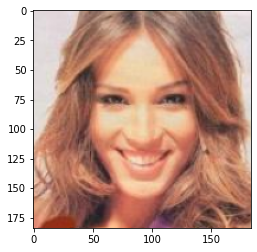

Ground Truth: [1]
probability_wavyhair: 0.99562967
Wavy_hair
----------------------------------------


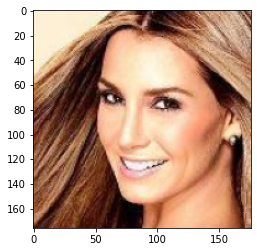

Ground Truth: [0]
probability_wavyhair: 0.93264496
Wavy_hair
----------------------------------------


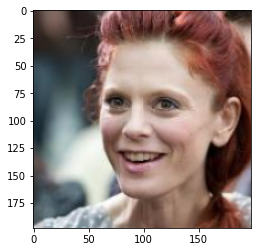

Ground Truth: [0]
probability_wavyhair: 0.13810974
Not Wavy_hair


In [67]:
pred_wavyhair("./img_align_celeba//img_align_celeba//000028.jpg")
print("----------------------------------------")
pred_wavyhair("./img_align_celeba//img_align_celeba//000001.jpg")
print("----------------------------------------")
pred_wavyhair("./img_align_celeba//img_align_celeba//000002.jpg")